In [1]:
import pandas as pd
import os
from sklearn.metrics import precision_recall_fscore_support 
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier
from sklearn.model_selection import cross_validate

# 📂DATA : 3 Classes

In [23]:
fold = 3

In [24]:
path = "/home/kannika/code/Rheology2023/Rheology_Blood/DataBlood_Viscosity_TrainML_3Fold_split3class.csv"
data_feature = pd.read_csv(path)
print(data_feature.shape)
print("-"*100)
print(f"All Fold : {set(data_feature.fold)}")
## Split Train data Set
feature_train = data_feature[data_feature["fold"]!=fold].reset_index(drop=True)
print(f"Train Set : Fold ==> {set(feature_train.fold)}")
print("Train = ", feature_train.shape)
## Split Valid data Set
feature_valid = data_feature[data_feature["fold"]==fold].reset_index(drop=True)
print(f"Valiadtion Set : Fold ==> {set(feature_valid.fold)}")
print("Validation = ", feature_valid.shape)
## Print DataFrame
feature_valid.head()

(51, 9)
----------------------------------------------------------------------------------------------------
All Fold : {1, 2, 3}
Train Set : Fold ==> {1, 2}
Train =  (34, 9)
Valiadtion Set : Fold ==> {3}
Validation =  (17, 9)


,Unnamed: 0,Code,classes,subclass,fold,classes_binary,MCV,MCH,Hb
0,34,HN18,HN,No_Splenectomy,3,1.0,71.3,23.5,8.1
1,35,HN15,HN,No_Splenectomy,3,1.0,73.3,21.9,7.2
2,36,HN31,HN,No_Splenectomy,3,1.0,67.7,21.3,6.0
3,37,NBL11,NBL,Normal,3,0.0,55.5,17.9,13.7
4,38,NBL22,NBL,Normal,3,0.0,75.1,24.7,15.2


In [25]:
X_test = feature_valid[['MCV','MCH','Hb']]
y_test = feature_valid["subclass"]
print(X_test.shape)
print(y_test.shape)
print(y_test[0])

(17, 3)
(17,)
No_Splenectomy


In [26]:
print(len(set(y_test)))
print(set(y_test))

3
{'Normal', 'No_Splenectomy', 'Splenectomy'}


## 🚀Load Model

In [27]:
#load model
import pickle

model_path = f"/media/tohn/HDD/rheology2023/ML_Model/Blood_Viscosity/_3Classes/fold{fold}/XGboost_Model_Blood3Class_fold{fold}.pkl"
print(f"[INFO]: Load Model from: {model_path}")

with open(model_path, 'rb') as file:
    model = pickle.load(file)

[INFO]: Load Model from: /media/tohn/HDD/rheology2023/ML_Model/Blood_Viscosity/_3Classes/fold3/XGboost_Model_Blood3Class_fold3.pkl


In [28]:
import numpy as np

y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)
print(len(y_pred))
print(y_pred)

prob_list = list()
for i in range(0,len(y_prob)):
    result = y_prob[i]
    maxx = np.argmax(result)
    prob_i = result[maxx]
    prob_list.append(prob_i)
print(len(prob_list))

17
['Splenectomy' 'Splenectomy' 'Splenectomy' 'Normal' 'Normal' 'Normal'
 'Splenectomy' 'No_Splenectomy' 'No_Splenectomy' 'No_Splenectomy'
 'No_Splenectomy' 'Splenectomy' 'Normal' 'Splenectomy' 'Splenectomy'
 'Splenectomy' 'Splenectomy']
17


In [29]:
print(prob_list)

[0.43465763, 0.57521355, 0.4121936, 0.45457712, 0.6467385, 0.664904, 0.51385957, 0.654214, 0.654214, 0.654214, 0.654214, 0.51385957, 0.664904, 0.5000165, 0.52644545, 0.41248643, 0.41248643]


In [30]:
feature_valid['Category'] = y_pred
feature_valid['Prob'] = prob_list
feature_valid.head()

,Unnamed: 0,Code,classes,subclass,fold,classes_binary,MCV,MCH,Hb,Category,Prob
0,34,HN18,HN,No_Splenectomy,3,1.0,71.3,23.5,8.1,Splenectomy,0.434658
1,35,HN15,HN,No_Splenectomy,3,1.0,73.3,21.9,7.2,Splenectomy,0.575214
2,36,HN31,HN,No_Splenectomy,3,1.0,67.7,21.3,6.0,Splenectomy,0.412194
3,37,NBL11,NBL,Normal,3,0.0,55.5,17.9,13.7,Normal,0.454577
4,38,NBL22,NBL,Normal,3,0.0,75.1,24.7,15.2,Normal,0.646739


In [31]:
act = feature_valid['subclass'].tolist()
pred = feature_valid['Category'].tolist()
#Marking the Confusion Matrix
from sklearn.metrics import classification_report,confusion_matrix
# confusion_matrix(act, pred)
cmat = confusion_matrix(act, pred)
print('Classifier accuracy = {}%'.format((100.*np.trace(cmat))/(np.sum(cmat))))
print("="*100)
print(classification_report(act, pred))#performance

Classifier accuracy = 58.8235294117647%
                precision    recall  f1-score   support

No_Splenectomy       0.50      0.40      0.44         5
        Normal       1.00      0.67      0.80         6
   Splenectomy       0.44      0.67      0.53         6

      accuracy                           0.59        17
     macro avg       0.65      0.58      0.59        17
  weighted avg       0.66      0.59      0.60        17



Text(0.5, 20.59375, 'Predicted label')

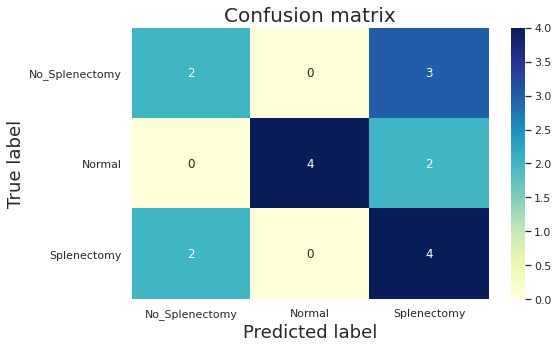

In [32]:
#create CF 
data = {'Actual': act,'Predicted' : pred,}
df = pd.DataFrame(data, columns=['Actual','Predicted'])
conf_mat = pd.crosstab(df['Actual'],df['Predicted'],rownames=['Actual'],colnames=['Predicted'])

#Confusion matrix
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
cm = confusion_matrix(act, pred)

#plot Confusion matrix
import seaborn as sns
sns.set()
fig, ax = plt.subplots(figsize=(8, 5))

ax = sns.heatmap(conf_mat, annot=True, fmt="d", cmap="YlGnBu") #Blues,Oranges,Reds
ax.set_title('Confusion matrix',fontsize=20)
ax.set_ylabel('True label',fontsize=18)
ax.set_xlabel('Predicted label',fontsize=18)